TRAINING CNN ACROSS MULTIPLE SNRs
SNR(dB)   Accuracy  



/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.7121 - loss: 0.6036 - val_accuracy: 0.9343 - val_loss: 0.1960
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9324 - loss: 0.1827 - val_accuracy: 0.9467 - val_loss: 0.1407
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9439 - loss: 0.1610 - val_accuracy: 0.9457 - val_loss: 0.1433
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9491 - loss: 0.1421 - val_accuracy: 0.9524 - val_loss: 0.1193
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9471 - loss: 0.1410 - val_accuracy: 0.9590 - val_loss: 0.1158
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9544 - loss: 0.1205 - val_accuracy: 0.9562 - val_loss: 0.1147
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9625 - loss: 0.1107 - val_accuracy: 0.9562 - val_loss: 0.1165
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9556 - loss: 0.1205 - val_accuracy: 0.9619 - val_lo

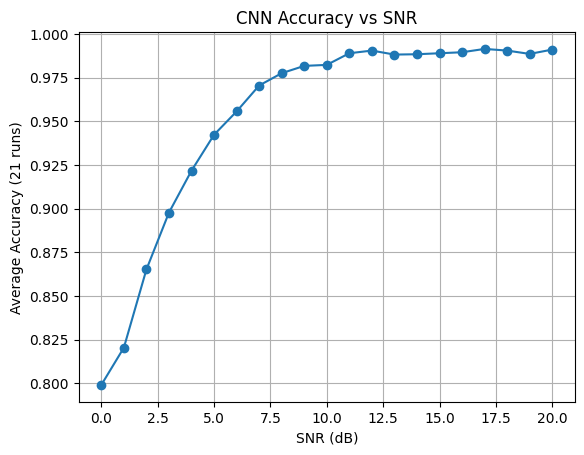

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

def generate_bpsk_signal(num_samples, SNR_dB):
    Kr = 10
    power = 1
    s = np.sqrt((Kr / 2) * (Kr + 1) * power)
    sigma = power / np.sqrt(2 * (Kr + 1))

    avg_path_gains = np.array([0, -0.9, -4.9, -8, -7.8, -23.9])
    n_tap = len(avg_path_gains)

    tap_var = 10 ** (avg_path_gains / 10)
    tap_var = tap_var / np.sum(tap_var)

    hn1 = (1 / np.sqrt(2)) * (1 / np.sqrt(n_tap)) * sigma * np.sqrt(tap_var) * \
          ((np.random.randn(1, n_tap) + s) + 1j * (np.random.randn(1, n_tap) + s))

    bits = np.random.randint(0, 2, num_samples)
    symbols = 2 * bits - 1

    faded_signal = np.zeros(num_samples, dtype=complex)
    for i in range(n_tap):
        faded_signal += hn1[0, i] * np.roll(symbols, i)

    noise = (1 / np.sqrt(2)) * (np.random.randn(num_samples) + 1j * np.random.randn(num_samples))
    SNR_linear = 10 ** (SNR_dB / 10.0)
    noise_power = np.var(faded_signal) / SNR_linear
    noisy_symbols = faded_signal + np.sqrt(noise_power) * noise
    return noisy_symbols


def generate_qpsk_signal(num_samples, SNR_dB):
    Kr = 10
    power = 1
    s = np.sqrt((Kr / 2) * (Kr + 1) * power)
    sigma = power / np.sqrt(2 * (Kr + 1))

    avg_path_gains = np.array([0, -0.9, -4.9, -8, -7.8, -23.9])
    n_tap = len(avg_path_gains)

    tap_var = 10 ** (avg_path_gains / 10)
    tap_var = tap_var / np.sum(tap_var)

    hn1 = (1 / np.sqrt(2)) * (1 / np.sqrt(n_tap)) * sigma * np.sqrt(tap_var) * \
          ((np.random.randn(1, n_tap) + s) + 1j * (np.random.randn(1, n_tap) + s))

    bits = np.random.randint(0, 4, num_samples)
    symbols = np.exp(1j * (np.pi / 4 + np.pi / 2 * bits))

    faded_signal = np.zeros(num_samples, dtype=complex)
    for i in range(n_tap):
        faded_signal += hn1[0, i] * np.roll(symbols, i)

    noise = (1 / np.sqrt(2)) * (np.random.randn(num_samples) + 1j * np.random.randn(num_samples))
    SNR_linear = 10 ** (SNR_dB / 10.0)
    noise_power = np.var(faded_signal) / SNR_linear
    noisy_symbols = faded_signal + np.sqrt(noise_power) * noise
    return noisy_symbols


def extract_cnn_features(signal, block_size=16):
    real = np.real(signal)
    imag = np.imag(signal)

    num_blocks = len(signal) // block_size
    features = []
    for i in range(num_blocks):
        start = i * block_size
        end = start + block_size
        block = np.stack([real[start:end], imag[start:end]], axis=1)
        features.append(block)

    return np.array(features)


def build_dataset(num_samples, SNR_dB, block_size=16):
    bpsk_signal = generate_bpsk_signal(num_samples, SNR_dB)
    qpsk_signal = generate_qpsk_signal(num_samples, SNR_dB)

    bpsk_features = extract_cnn_features(bpsk_signal, block_size)
    qpsk_features = extract_cnn_features(qpsk_signal, block_size)

    bpsk_labels = np.zeros(len(bpsk_features))
    qpsk_labels = np.ones(len(qpsk_features))

    X = np.vstack((bpsk_features, qpsk_features))
    y = np.hstack((bpsk_labels, qpsk_labels))

    return X, y


num_samples = 2000
block_size = 16
SNRs = range(0, 21)

print(f"TRAINING CNN ACROSS MULTIPLE SNRs\n{'SNR(dB)':<10}{'Accuracy':<10}\n")

X_all, y_all = [], []
for SNR_dB in SNRs:
    X, y = build_dataset(num_samples, SNR_dB, block_size)
    X_all.append(X)
    y_all.append(y)

X_all = np.vstack(X_all)
y_all = np.hstack(y_all)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

model = Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(block_size, 2)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20, batch_size=64, verbose=1)

accuracies = {SNR: 0.0 for SNR in SNRs}

for i in range(21):
    for SNR_dB in SNRs:
        X, y = build_dataset(num_samples, SNR_dB, block_size)
        loss, acc = model.evaluate(X, y, verbose=0)
        accuracies[SNR_dB] += acc

for SNR_dB in SNRs:
    accuracies[SNR_dB] /= 21.0

avg_accuracies = [accuracies[SNR] for SNR in SNRs]

plt.figure()
plt.plot(SNRs, avg_accuracies, marker='o')
plt.title("CNN Accuracy vs SNR")
plt.xlabel("SNR (dB)")
plt.ylabel("Average Accuracy (21 runs)")
plt.grid(True)
plt.show()
